___
# Lecture 2 - Data Manipulation, Pre-processing, and Descriptive Statistics
___

## Review

* We can subset pandas dataframes using `.iloc` and `.loc`
* You can access columns in dataframes by `df.column1` or `df["column1"]`
* We can handle NaNs in our data with `.dropna()` or `.fillna()`

## Lesson Overview

Today you will learn how to use perform basic data QC with dimensionality reduction and conditional filtering. We will also get more practice with data visualization.

## Lesson Outline

#### (1) [Load data with pandas](#1)
#### (2) [Data cleaning](#2)
* [Sample quality control with PCA](#2a)
* [Gene quality control](#2b)
* [Write QC'd data to new file](#2c)

#### (3) [More data visualization](#3)
#### (4) [Extra challenges](#4)
#### (5) [Extra Resources](#5)

## 0 - Setup and data introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

### RNAseq Dataset

There are two datasets here, the first is the sample sheet (doe - design of experiment) and the second is the abundance file.  The structure of the abundance table is the first two columns are ensembl gene ID and gene symbols, and the remaining columns are samples which correspond to the sample column in the doe file. The values are ln(TPM). 

The RNAseq data from liver cells grown in a plate and sampled at baseline (day 0) or split into 3 groups and sampled at day 5:  BSA (control), or FFA_LPS (treatment 1) or TMC (treatment 2). Both of these treatments are design to induce the integrated stress response pathway in the liver cell. 

## 1 - Load data with `Pandas` <a class="anchor" id="1"></a>

In [2]:
pd.read_csv("inSphero.abundance.table_edit190410.csv").head()

,gene_id,symbol,baseline_1,baseline_2,baseline_3,DE.BSA.DMSO.day5_2,DE.BSA.DMSO.day5_3,DE.FFA.LPS.day5_1,DE.FFA.LPS.day5_2,DE.FFA.LPS.day5_3,DE.TMC.day5_1,DE.TMC.day5_2,DE.TMC.day5_3
0,ENSG00000248155,WI2-89927D4.1,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,0.279975,-4.616600,-0.490349,-4.298650,-4.748550
1,ENSG00000274584,RP11-819M15.2,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-4.714800,-4.616600,-4.720340,-4.298650,-4.748550
2,ENSG00000228826,RP11-344P13.4,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-0.727078,-4.616600,-0.665645,-0.203773,-0.799714
3,ENSG00000278847,RP11-414C23.1,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-4.714800,-4.616600,-4.720340,-4.298650,-0.356121
4,ENSG00000272389,CTC-487M23.7,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-4.714800,-0.865132,-4.720340,-4.298650,-4.748550


Lets set the `gene_id` column to the index. 

In [4]:
expr_data_w_meta = pd.read_csv("inSphero.abundance.table_edit190410.csv", index_col=0)

In [5]:
expr_data_w_meta.head()

,symbol,baseline_1,baseline_2,baseline_3,DE.BSA.DMSO.day5_2,DE.BSA.DMSO.day5_3,DE.FFA.LPS.day5_1,DE.FFA.LPS.day5_2,DE.FFA.LPS.day5_3,DE.TMC.day5_1,DE.TMC.day5_2,DE.TMC.day5_3
gene_id,,,,,,,,,,,,
ENSG00000248155,WI2-89927D4.1,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,0.279975,-4.616600,-0.490349,-4.298650,-4.748550
ENSG00000274584,RP11-819M15.2,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-4.714800,-4.616600,-4.720340,-4.298650,-4.748550
ENSG00000228826,RP11-344P13.4,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-0.727078,-4.616600,-0.665645,-0.203773,-0.799714
ENSG00000278847,RP11-414C23.1,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-4.714800,-4.616600,-4.720340,-4.298650,-0.356121
ENSG00000272389,CTC-487M23.7,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-4.714800,-0.865132,-4.720340,-4.298650,-4.748550


The data has mixed types (`strings` and `floats`). Sometimes it is best to separate these two from each other so you can easily do stats on the `floats`!

### Notice that we have replicates!

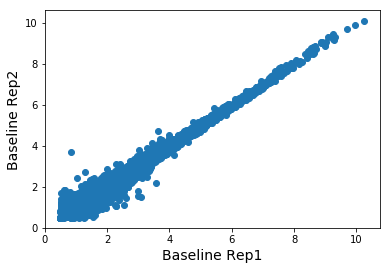

In [6]:
plt.scatter(expr_data_w_meta["baseline_1"],expr_data_w_meta["baseline_2"])
plt.xlabel("Baseline Rep1",fontsize=14)
plt.ylabel("Baseline Rep2",fontsize=14)
plt.show()

In [7]:
from scipy import stats

In [8]:
corr = stats.pearsonr(expr_data_w_meta["baseline_1"],expr_data_w_meta["baseline_2"])
corr

(0.9961517923245065, 0.0)

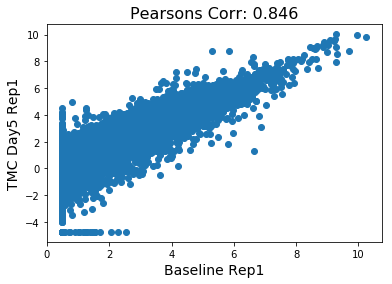

In [9]:
plt.scatter(expr_data_w_meta["baseline_1"],expr_data_w_meta["DE.TMC.day5_1"])
corr = stats.pearsonr(expr_data_w_meta["baseline_1"],expr_data_w_meta["DE.TMC.day5_1"])

# We can add the correlation to the title
plt.title("Pearsons Corr: {}".format(np.round(corr[0],3)),fontsize=16)

plt.xlabel("Baseline Rep1",fontsize=14)
plt.ylabel("TMC Day5 Rep1",fontsize=14)
plt.show()

<h3 style="color:red;"> Exercise: Split dataframe into two parts </h3>

Subset `expr_data_w_meta` to contain only the column `symbol` and save to new variable called `annots` 

**Hint:** Remember `loc` from *Lesson1*

In [11]:
annots = expr_data_w_meta.loc[:,["symbol"]]

To get only the floats we have to subset `expr_data_w_meta`  to the remainder of the data. Use the dataframes `drop` function to exclude column `symbol` from the data. Set to new variable called `expr_data`.

In [12]:
expr_data = expr_data_w_meta.drop("symbol",axis=1)

Lets visualize the final results with `head`

In [13]:
annots.head()

,symbol
gene_id,
ENSG00000248155,WI2-89927D4.1
ENSG00000274584,RP11-819M15.2
ENSG00000228826,RP11-344P13.4
ENSG00000278847,RP11-414C23.1
ENSG00000272389,CTC-487M23.7


In [30]:
expr_data.head()

,baseline_1,baseline_2,baseline_3,DE.BSA.DMSO.day5_2,DE.BSA.DMSO.day5_3,DE.FFA.LPS.day5_1,DE.FFA.LPS.day5_2,DE.FFA.LPS.day5_3,DE.TMC.day5_1,DE.TMC.day5_2,DE.TMC.day5_3
gene_id,,,,,,,,,,,
ENSG00000248155,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,0.279975,-4.616600,-0.490349,-4.298650,-4.748550
ENSG00000274584,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-4.714800,-4.616600,-4.720340,-4.298650,-4.748550
ENSG00000228826,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-0.727078,-4.616600,-0.665645,-0.203773,-0.799714
ENSG00000278847,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-4.714800,-4.616600,-4.720340,-4.298650,-0.356121
ENSG00000272389,0.496074,0.496074,0.496074,-0.627376,-0.627376,-4.61901,-4.714800,-0.865132,-4.720340,-4.298650,-4.748550


In [14]:
expr_data.shape

(21519, 11)

## 2 - Data cleaning <a class="anchor" id="2"></a>

### Visualize hi-dimentional data and perform sample QC with principal components analysis (`PCA`) <a class="anchor" id="2a"></a>

`PCA` is a method for performing *unsupervised* dimensionality reduction.

![](https://i.stack.imgur.com/G7Gkv.png)

`Sklearn` is a powerful *Python* library that contains functions for machine learning. To learn more check out the [documentation](https://scikit-learn.org/stable/modules/unsupervised_reduction.html).

In [15]:
from sklearn.decomposition import PCA

Lets get the **first two** `principal components` (PCs) of our dataset

In [16]:
pca = PCA(n_components=2)
data_pcs = pca.fit_transform(expr_data.T)

In [17]:
data_pcs.shape

(11, 2)

In [18]:
data_pcs

array([[ 141.62858564,   18.02693589],
       [ 141.85090663,   16.62440468],
       [ 141.87920854,   16.70108084],
       [  64.74972037,    1.14917163],
       [  64.39188228,    1.87949261],
       [ -72.85627333,  -83.79353834],
       [ -65.70112788,  -81.71419568],
       [ -66.78381542,  -84.85722676],
       [-104.59842214,   39.74377233],
       [-139.67643893,  117.05826415],
       [-104.88422576,   39.18183866]])

<h3 style="color:red;"> What happens if we don't transpose our data? </h3>

What is the `variance` explained by these `PCs`?

In [19]:
pca.explained_variance_ratio_

array([0.57178728, 0.1777357 ])

<h3 style="color:red;"> Exercise: Convert numpy array into a pandas dataframe </h3>

Use the function `pd.DataFrame()` and remember the three most important components of dataframes are the `data`, `columns`, `index`

Set this to a variable named `data_pcs_df` 

In [20]:
data_pcs.shape

(11, 2)

In [21]:
data_pcs_df = pd.DataFrame(data=data_pcs,index=expr_data.columns,columns=["PC1","PC2"])

Now that our data is only 2D lets plot it using `plt.scatter()`

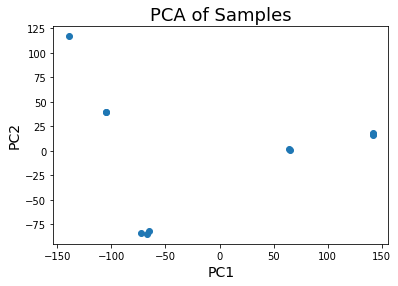

In [22]:
plt.scatter(x=data_pcs_df.PC1, y=data_pcs_df.PC2)
plt.xlabel("PC1",fontsize=14)
plt.ylabel("PC2",fontsize=14)
plt.title("PCA of Samples",fontsize=18)
plt.show()

Lets make this plot better by adding colors for each condition, a legend, and changing the markers!

In [129]:
print("\n".join(data_pcs_df.index))

baseline_1
baseline_2
baseline_3
DE.BSA.DMSO.day5_2
DE.BSA.DMSO.day5_3
DE.FFA.LPS.day5_1
DE.FFA.LPS.day5_2
DE.FFA.LPS.day5_3
DE.TMC.day5_1
DE.TMC.day5_2
DE.TMC.day5_3


In [23]:
data_pcs_df.index

Index(['baseline_1', 'baseline_2', 'baseline_3', 'DE.BSA.DMSO.day5_2',
       'DE.BSA.DMSO.day5_3', 'DE.FFA.LPS.day5_1', 'DE.FFA.LPS.day5_2',
       'DE.FFA.LPS.day5_3', 'DE.TMC.day5_1', 'DE.TMC.day5_2', 'DE.TMC.day5_3'],
      dtype='object')

In [24]:
print("\n".join(data_pcs_df.index))

baseline_1
baseline_2
baseline_3
DE.BSA.DMSO.day5_2
DE.BSA.DMSO.day5_3
DE.FFA.LPS.day5_1
DE.FFA.LPS.day5_2
DE.FFA.LPS.day5_3
DE.TMC.day5_1
DE.TMC.day5_2
DE.TMC.day5_3


In [27]:
list(zip(data_pcs_df.index,colors))

NameError: name 'colors' is not defined

In [26]:
for sample,color in zip(data_pcs_df.index,colors):
    print(sample)
    print(color)

NameError: name 'colors' is not defined

In [28]:
colors = ["blue"]*3+["purple"]*2+["red"]*3+["green"]*3

In [29]:
expr_data.columns[0].split("_")

['baseline', '1']

In [30]:
pd.unique([col.split("_")[0] for col in expr_data.columns])

array(['baseline', 'DE.BSA.DMSO.day5', 'DE.FFA.LPS.day5', 'DE.TMC.day5'],
      dtype=object)

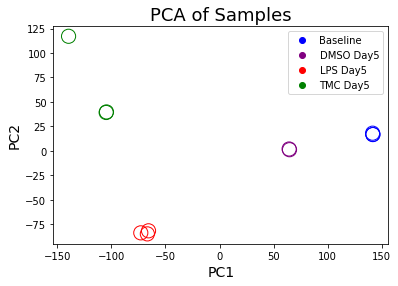

In [31]:
plt.scatter(x=data_pcs_df.PC1, y=data_pcs_df.PC2,
            s=200, marker="o",
            facecolors="none", edgecolors = colors)

# Create a custom legend
legend_markers = [Line2D([0],[0],marker='o',color='blue',linewidth=0),
                 Line2D([0],[0],marker='o',color='purple',linewidth=0),
                 Line2D([0],[0],marker='o',color='red',linewidth=0),
                 Line2D([0],[0],marker='o',color='green',linewidth=0)]

plt.legend(legend_markers,["Baseline", "DMSO Day5","LPS Day5","TMC Day5"])
plt.xlabel("PC1",fontsize=14)
plt.ylabel("PC2",fontsize=14)
plt.title("PCA of Samples",fontsize=18)
plt.show()

Looks like we have an **outlier** in our data. Since all other replicates align closely maybe we should remove it.

<H3 style="color:red;"> Exercise: Figure out which data point is the outlier and drop it from our expression data </H3>

Hint: Look at `data_pcs_df`! We can remove a sample with `drop()` like we did before... 

We should also set this to a new variable named `expr_data_no_outlier`.

In [32]:
from scipy.spatial.distance import euclidean

In [33]:
euclidean(data_pcs_df.PC1,data_pcs_df.PC2)

403.46813383516945

In [34]:
expr_data_no_outlier = expr_data.drop("DE.TMC.day5_2",axis=1)

### Filter genes with low expression <a class="anchor" id="2b"></a>

In [35]:
(np.exp(expr_data_no_outlier.iloc[:,:5])>1)

,baseline_1,baseline_2,baseline_3,DE.BSA.DMSO.day5_2,DE.BSA.DMSO.day5_3
gene_id,,,,,
ENSG00000248155,True,True,True,False,False
ENSG00000274584,True,True,True,False,False
ENSG00000228826,True,True,True,False,False
ENSG00000278847,True,True,True,False,False
ENSG00000272389,True,True,True,False,False
ENSG00000254539,True,True,True,False,False
ENSG00000243779,True,True,True,False,False
ENSG00000233870,True,True,True,False,False
ENSG00000253227,True,True,True,False,False


In [36]:
cond = (np.exp(expr_data_no_outlier.iloc[:,:5])>1).all(axis=1)

In [37]:
expr_data_no_outlier_filter = expr_data_no_outlier.loc[cond,:]

In [38]:
expr_data_no_outlier_filter.shape

(14271, 10)

<h3 style="color:red;"> What do you think will happen to our PCs if we were to re-calculate with the subset of genes? </h3>

### Write filtered data to new file

<h3 style="color:red;"> Exercise: Re-join the gene annotations with the now filtered data </h3>

Join `annots` with `expr_data_no_outlier_filter`

**Hint:** We don't want to end up with `NaNs` in our dataset so think of how we can avoid them! Also, the order of columns depends on which dataframe you join on... 

**Example:** df1, df2

If we use `df1.join(df2)` the columns for df1 will come first

Set the output to a variable named `expr_data_no_outlier_filter_w_meta`

In [40]:
annots.join(expr_data_no_outlier_filter).dropna().head()
?annots.join

In [41]:
expr_data_no_outlier_filter_w_meta = annots.join(expr_data_no_outlier_filter,how="right",)

Now lets write the data to a new file using *pandas* `to_csv`

In [42]:
expr_data_no_outlier_filter_w_meta.to_csv("inSphero.abundance.table_edit190410_filtered.csv")

## 3 - More data visualization <a class="anchor" id="3"></a>

### Create boxplot of gene expression across conditions

In [107]:
expr_data_no_outlier_filter.values.shape

(14271, 10)

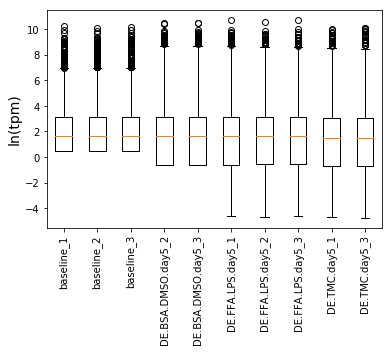

In [109]:
plt.boxplot(x=expr_data_no_outlier.values, 
            labels=expr_data_no_outlier_filter.columns)
plt.xticks(rotation=90)
plt.ylabel("ln(tpm)",fontsize=14)
plt.show()

### Plot histogram of average expression values

In [43]:
-np.log(0.05)

2.995732273553991

In [44]:
expr_data_no_outlier_filter.mean(axis=1)

gene_id
ENSG00000241362   -0.447829
ENSG00000260571   -1.408627
ENSG00000205693   -0.539252
ENSG00000239775    0.871678
ENSG00000259444   -0.476246
ENSG00000235272    0.310754
ENSG00000263432    0.356033
ENSG00000260418    0.307074
ENSG00000220323    0.387530
ENSG00000248709   -1.680078
ENSG00000231702    0.073037
ENSG00000256553   -0.328715
ENSG00000258732    0.193095
ENSG00000254719   -1.116686
ENSG00000256590   -1.795784
ENSG00000237854    0.769091
ENSG00000230397   -0.601672
ENSG00000259760    0.964645
ENSG00000255689   -2.149403
ENSG00000235576    0.755127
ENSG00000157368    0.986661
ENSG00000235077    0.634444
ENSG00000238005   -0.537859
ENSG00000267405   -0.541277
ENSG00000260342    0.337063
ENSG00000232445    1.046668
ENSG00000146963    1.409715
ENSG00000131400    0.056329
ENSG00000211896    3.570754
ENSG00000185269    0.481257
                     ...   
ENSG00000247596    4.342714
ENSG00000108298    7.047541
ENSG00000196230    5.471113
ENSG00000145391    3.272748
ENSG00000265

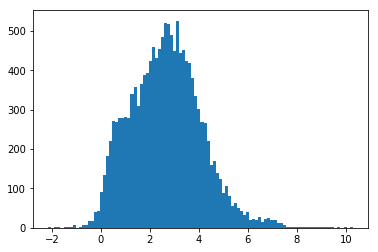

In [45]:
plt.hist(expr_data_no_outlier_filter.mean(axis=1),bins=100)
plt.show()

## 4 - Extra challenges <a class="anchor" id="4"></a>

### Extract the top 10 PCs and make a bar plot of the variance explained

In [49]:

pca = PCA(n_components=10)
data_pcs = pca.fit_transform(expr_data.T)

data_pcs

data_pcs_df = pd.DataFrame(data=data_pcs, 
                           columns=np.arange(1,11), 
                           index=expr_data.columns)
print(pca.explained_variance_ratio_)

[0.57178728 0.1777357  0.08683496 0.04788049 0.04616285 0.04415977
 0.02137181 0.00222481 0.00104227 0.00080006]


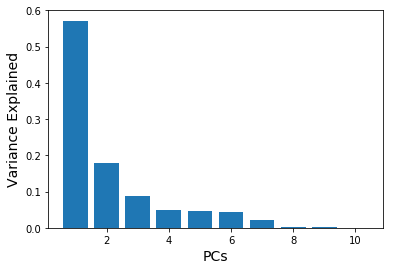

In [50]:
plt.bar(x = np.arange(1,11), height = pca.explained_variance_ratio_)
plt.xlabel("PCs", fontsize=14)
plt.ylabel("Variance Explained", fontsize=14)
plt.show()

### Plot PC2 vs PC3 or additional PCs

In [ ]:
plt.scatter(x=data_pcs_df.loc[:,2], y=data_pcs_df.loc[:,3],
            s=200, marker="o",
            facecolors="none", edgecolors = colors)

legend_markers = [Line2D([0],[0],marker='o',color='blue',linewidth=0),
                 Line2D([0],[0],marker='o',color='purple',linewidth=0),
                 Line2D([0],[0],marker='o',color='red',linewidth=0),
                 Line2D([0],[0],marker='o',color='green',linewidth=0)]

plt.legend(legend_markers,["Baseline", "DMSO Day5","LPS Day5","TMC Day5"])
plt.xlabel("PC2",fontsize=14)
plt.ylabel("PC3",fontsize=14)
plt.title("PCA of Samples",fontsize=18)
plt.show()

## 5 - Extra Resources <a class="anchor" id="5"></a>

- [PCA with python](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)
- [PCA details](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579)
- [Plot enhancement with **seaborn**](https://seaborn.pydata.org)